|<div style="width:300px"><img src="https://www.ufz.de/static/custom/weblayout/DefaultInternetLayout/img/logos/ufz_transparent_de_blue.png" width="300"/></div>|<div style="width:300px"><img src="https://discourse.opengeosys.org/uploads/default/original/1X/a288c27cc8f73e6830ad98b8729637a260ce3490.png" width="300"/></div>|<div style="width:330px"><img src="https://github.com/nagelt/Teaching_Scripts/raw/9d9e29ecca4b04eaf7397938eacbf116d37ddc93/Images/TUBAF_Logo_blau.png" width="300"/></div>|
|---|---|--:|

# Advective-Diffusive transport (Ogata-Banks)

The Ogata-Banks analytical solution of the 1D advection-dispersion equation of heat for a point $x$ in time $t$ reads:

$ T(x,t) = \frac{T_0-T_i}{2}\left[\operatorname{erfc}\left(\frac{x-v_xt}{\sqrt{4Dt}}\right)+\operatorname{exp}\left(\frac{xv_x}{D}\right)\operatorname{erfc}\left(\frac{x+v_xt}{\sqrt{4Dt}}\right)\right]+T_i$

where $T_0$ is the constant temperature at $x=0$ and $T_i$ is initial temperature at $t=0$, $v_x$ is the constant velocity of the fluid medium, and D is thermal diffusivity given by

$D=\frac{\lambda}{\rho c_p}$

where $\lambda$ is the thermal heat conductivity, $\rho$ is density and $c_p$ is the specific heat capacity of the fluid medium.

---

The weak form of the energy balance equation (in simplified form for single-phase fluid L and without gravity) in OGS-TH2M is:

$
\int_\Omega
(\Sigma_\alpha\rho_\alpha u_\alpha)'_\mathrm{S}
\,\delta T\,d\Omega
-\int_\Omega \rho_\mathrm{L} h_\mathrm{L}\mathbf{w}_\mathrm{LS}\cdot\nabla\delta T\,d\Omega
+\int_\Omega \lambda^\mathrm{eff}\nabla T\cdot\nabla\,\delta T\,d\Omega
+\int_{\partial\Omega}\underbrace{\left(\lambda^\mathrm{eff}\nabla T
-\rho_\mathrm{L}h_\mathrm{L}\mathbf{w}_\mathrm{LS}\right)\cdot\mathbf{n}}_{=-q_n}\,\delta T\,d\Gamma
$

This results in an energy contribution across the Neumann boundaries that is dependent on the flowing medium and which may have to be compensated for by the boundary conditions.

## Material properties

In [1]:
# Porosity
phi = 0.15

# Effective properties of the porous medium
rho_eff = 1000
cp_eff = 2000
lambda_eff = 2.2

# Thermal diffusivity
alpha = lambda_eff / (rho_eff * cp_eff)

## Problem definition

In [2]:
# Initial temperature
T_i = 300
# Boundary condition left
T_0 = 330

# Time - domain

# Helper function to simplify conversions from seconds to days and back


def day(value):
    # Converts seconds to days
    return value / 86400


def second(value):
    # Converts days to seconds
    return value * 86400


# Time discretisation
delta_time = second(0.5)
max_time = second(500)

domain_size = 50  # metre

# Groundwater velocity
v_x = 1.5e-6

## Analytical solution

In [3]:
import numpy as np
from scipy.special import erfc


def OgataBanks(t, x):
    if not isinstance(t, int) and isinstance(t, np.float64):
        # In order to avoid a division by zero, the time field is increased
        # by a small time unit at the start time (t=0). This should have no
        # effect on the result.
        tiny = np.finfo(np.float64).tiny
        t[t < tiny] = tiny

    d = np.sqrt(4.0 * alpha * t)
    a1 = np.divide((x - v_x * t), d, where=t != 0)
    a2 = np.divide((x + v_x * t), d, where=t != 0)

    return (T_0 - T_i) / 2.0 * (erfc(a1) + np.exp(v_x * x / alpha) * erfc(a2)) + T_i

## Numerical solution

In [4]:
import os
from pathlib import Path

out_dir = Path(os.environ.get("OGS_TESTRUNNER_OUT_DIR", "_out"))
if not out_dir.exists():
    out_dir.mkdir(parents=True)

In [5]:
import ogstools as ogs

# Modifies the project file of the original cTest so that the simulation runs for a longer time.
model = ogs.Project(input_file="ogata-banks.prj", output_file=f"{out_dir}/modified.prj")
model.replace_text(max_time, xpath="./time_loop/processes/process/time_stepping/t_end")
model.replace_text(
    delta_time,
    xpath="./time_loop/processes/process/time_stepping/timesteps/pair/delta_t",
)
# Output every timestep
model.replace_text(1, xpath="./time_loop/output/timesteps/pair/each_steps")
model.write_input()

True

In [6]:
# Run OGS
model.run_model(logfile=f"{out_dir}/out.txt", args=f"-o {out_dir} -m . -s .")

OGS finished with project file modified.prj.
Execution took 85.29733037948608 s


In [7]:
# Colors
cls1 = ["#4a001e", "#731331", "#9f2945", "#cc415a", "#e06e85"]
cls2 = ["#0b194c", "#163670", "#265191", "#2f74b3", "#5d94cb"]

In [8]:
import vtuIO

pvdfile = vtuIO.PVDIO(f"{out_dir}/result_ogata-banks.pvd", dim=2)

# Get all written timesteps
time = pvdfile.timesteps

# Select individual timesteps for T vs. x plots for plotting
time_steps = [second(10), second(100), second(200), second(300), second(500)]

# 'Continuous' space axis for T vs. x plots for plotting
length = np.linspace(0, domain_size, 101)

# Draws a line through the domain for sampling results
x_axis = [(i, 0, 0) for i in length]

# Discrete locations for T vs. t plots
location = [1.0, 5.0, 10.0, 20.0, 50.0]

In [9]:
# The sample locations have to be converted into a 'dict' for vtuIO
observation_points = {"x=" + str(x): (x, 0.0, 0.0) for x in location}
# Samples temperature field at the observation points for all timesteps
T_over_t_at_x = pvdfile.read_time_series("temperature_interpolated", observation_points)

In [10]:
# Samples temperature field along the domain at certain timesteps
T_over_x_at_t = []
for t in range(len(time_steps)):
    T_over_x_at_t.append(
        pvdfile.read_set_data(time_steps[t], "temperature", pointsetarray=x_axis)
    )

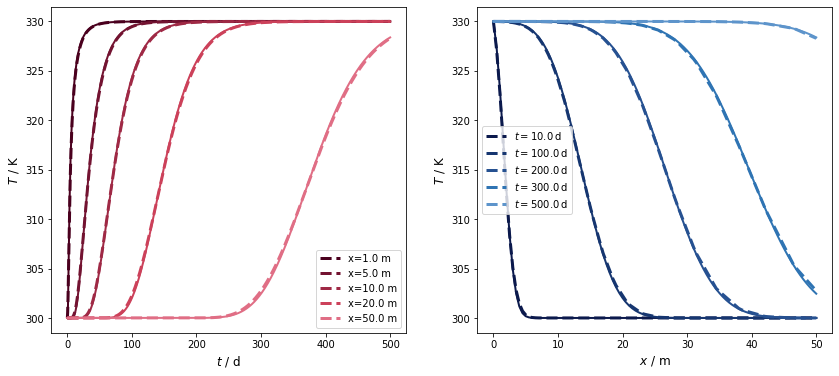

In [11]:
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (14, 6)
fig1, (ax1, ax2) = plt.subplots(1, 2)

ax1.set_xlabel("$t$ / d", fontsize=12)
ax1.set_ylabel("$T$ / K", fontsize=12)

# Plot Temperature over time at five locations
for key, _T in T_over_t_at_x.items():
    x = observation_points[key][0]
    # Plot numerical solution
    ax1.plot(
        day(time),
        T_over_t_at_x[key],
        color=cls1[location.index(x)],
        linewidth=3,
        linestyle="--",
        label=key + r" m",
    )
    # Plot analytical solution
    ax1.plot(
        day(time),
        OgataBanks(time, x),
        color=cls1[location.index(x)],
        linewidth=2,
        linestyle="-",
    )

ax2.set_xlabel("$x$ / m", fontsize=12)
ax2.set_ylabel("$T$ / K", fontsize=12)

# Plot Temperature over domain at five moments
for t in range(len(time_steps)):
    s = r"$t=$" + str(day(time_steps[t])) + r"$\,$d"
    ax2.plot(
        length, T_over_x_at_t[t], color=cls2[t], linewidth=3, linestyle="--", label=s
    )
    ax2.plot(
        length,
        OgataBanks(time_steps[t], length),
        color=cls2[t],
        linewidth=2,
        linestyle="-",
    )

ax1.legend()
ax2.legend()
fig1.savefig(f"{out_dir}/ogata_banks.pdf")

For this discretisation, the numerical solution approximates well to the analytical one. Finer resolutions in the time discretisation reduce the deviations considerably. In this benchmark it is easy to see that too coarse resolutions (especially in the time discretisation) yield very plausible results, which can, however, deviate considerably from the exact solution. An analysis of the von Neumann stability criterion is worthwhile here. This criterium demands

$$\text{Ne}=\frac{\alpha\Delta t}{\left(\Delta x\right)^2}\leq\frac{1}{2}$$

Evaluated for the problem at hand, the following value results:

In [12]:
# Spatial discretizations at the left boundary (smallest element)
dx = 0.17  # m

# von-Neumann-Stability-Criterion
Ne = alpha * delta_time / (dx * dx)
print(Ne)

1.644290657439446


The Neumann criterion is not met in this case. The smallest element is $\Delta x=0.17\text{m}$ in width. A suitable time step for this cell size would be

In [13]:
dt = 0.5 * (dx * dx) / alpha
print("Smallest timestep should not exceed", dt, "seconds.")

Smallest timestep should not exceed 13136.363636363638 seconds.


Repeating the test with this time step should give much smaller deviations to the exact solution.

However, the problem at hand has been spatially discretised where element widths are increasing from left to right. That means that the stability criteria is violated only at the left region of the domain.
The minimum width that an element should have is can be determined by:

In [14]:
dx = np.sqrt(2 * alpha * delta_time)
print("Minimum element size should be", dx, " metre.")

Minimum element size should be 0.3082855818879631  metre.


The elements located at approximately $x>1\text{m}$ satisfy this criterion, therefore the solution presented here can be accepted as an approximation of the exact solution.